# Inheritance klqp

In [1]:
from pCMF.misc import utils
from pCMF.models.pcmf import cavi_inh, svi_inh

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p,
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
T = 40.
S = 1.

In [4]:
# Run PCA
pca_U = PCA(n_components=K).fit_transform(np.log(Y_train + 1.))
pca_tsne = TSNE(n_components=2).fit_transform(pca_U)

In [5]:
# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('PCMF:')
infpcmf = cavi_inh.CoordinateAscentVI(Y_train, alpha, beta, pi_D, empirical_bayes=False)
infpcmf.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
pcmf_U = infpcmf.a[0] / infpcmf.a[1] # VI estimate is the mean of the variational approximation
pcmf_V = infpcmf.b[0] / infpcmf.b[1]
pcmf_tsne = TSNE(n_components=2).fit_transform(pcmf_U)

PCMF:
Iteration 33/4000. Log-likelihood: 25.880. Elapsed: 40 seconds


In [6]:
# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('PCMF:')
infpcmfeb = cavi_inh.CoordinateAscentVI(Y_train, alpha, beta, pi_D, empirical_bayes=True)
infpcmfeb.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
pcmfeb_U = infpcmfeb.a[0] / infpcmfeb.a[1] # VI estimate is the mean of the variational approximation
pcmfeb_V = infpcmfeb.b[0] / infpcmfeb.b[1]
pcmfeb_tsne = TSNE(n_components=2).fit_transform(pcmfeb_U)

PCMF:
Iteration 33/4000. Log-likelihood: 28.415. Elapsed: 41 seconds


In [7]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infpcmfsvi = svi_inh.StochasticVI(Y_train, alpha, beta, pi_D, minibatch_size=100, empirical_bayes=False)
infpcmfsvi.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
pcmfsvi_U = infpcmfsvi.a[0] / infpcmfsvi.a[1] # VI estimate is the mean of the variational approximation
pcmfsvi_V = infpcmfsvi.b[0] / infpcmfsvi.b[1]
pcmfsvi_tsne = TSNE(n_components=2).fit_transform(pcmfsvi_U)

Stochastic PCMF:
Iteration 147/4000. Log-likelihood: 29.207. Elapsed: 40 seconds


In [8]:
# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('Stochastic PCMF:')
infpcmfsvieb = svi_inh.StochasticVI(Y_train, alpha, beta, pi_D, minibatch_size=100, empirical_bayes=True)
infpcmfsvieb.run(n_iterations=4000, calc_ll=True, calc_silh=True, clusters=c_train, sampling_rate=S, max_time=T)
pcmfsvieb_U = infpcmfsvieb.a[0] / infpcmfsvieb.a[1] # VI estimate is the mean of the variational approximation
pcmfsvieb_V = infpcmfsvieb.b[0] / infpcmfsvieb.b[1]
pcmfsvieb_tsne = TSNE(n_components=2).fit_transform(pcmfsvieb_U)

Stochastic PCMF:
Iteration 142/4000. Log-likelihood: 26.231. Elapsed: 40 seconds


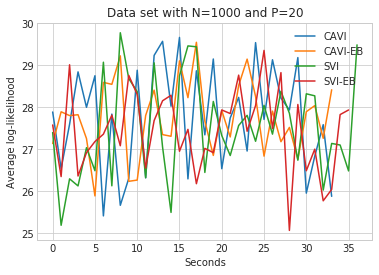

In [9]:
plt.plot(infpcmf.ll_time, label='CAVI')
plt.plot(infpcmfeb.ll_time, label='CAVI-EB')
plt.plot(infpcmfsvi.ll_time, label='SVI')
plt.plot(infpcmfsvieb.ll_time, label='SVI-EB')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

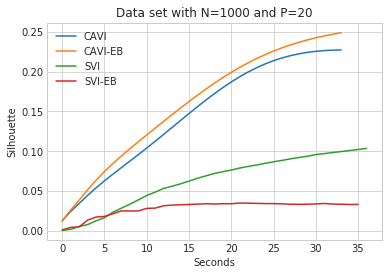

In [10]:
plt.plot(infpcmf.silh_time, label='CAVI')
plt.plot(infpcmfeb.silh_time, label='CAVI-EB')
plt.plot(infpcmfsvi.silh_time, label='SVI')
plt.plot(infpcmfsvieb.silh_time, label='SVI-EB')
plt.ylabel('Silhouette')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

In [11]:
pcmf_dll = utils.log_likelihood(Y_train, pcmf_U, pcmf_V, infpcmf.p)
pcmfeb_dll = utils.log_likelihood(Y_train, pcmfeb_U, pcmfeb_V, infpcmfeb.p)
pcmfsvi_dll = utils.log_likelihood(Y_train, pcmfsvi_U, pcmfsvi_V, infpcmfsvi.p)
pcmfsvieb_dll = utils.log_likelihood(Y_train, pcmfsvieb_U, pcmfsvieb_V, infpcmfsvieb.p)

scores = {'SVI': pcmfsvi_dll, 'CAVI-EB': pcmfeb_dll, 'SVI-EB': pcmfsvieb_dll, 'CAVI': pcmf_dll}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Full data log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Full data log-likelihood:
- CAVI: 27.9
- CAVI-EB: 27.8
- SVI: 27.7
- SVI-EB: 27.6


In [12]:
pcmf_holl = infpcmf.predictive_ll(Y_test)
pcmfeb_holl = infpcmfeb.predictive_ll(Y_test)
pcmfsvi_holl = infpcmfsvi.predictive_ll(Y_test)
pcmfsvieb_holl = infpcmfsvieb.predictive_ll(Y_test)

scores = {'SVI': pcmfsvi_holl, 'CAVI-EB': pcmfeb_holl, 'SVI-EB': pcmfsvieb_holl, 'CAVI': pcmf_holl}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Held-out log-likelihood:')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))

Held-out log-likelihood:
- CAVI: 29.1
- CAVI-EB: 29.0
- SVI: 28.9
- SVI-EB: 28.8


In [13]:
true_silh = silhouette_score(U_train, c_train)
pcmf_silh = silhouette_score(pcmf_U, c_train)
pcmfeb_silh = silhouette_score(pcmfeb_U, c_train)
pcmfsvi_silh = silhouette_score(pcmfsvi_U, c_train)
pcmfsvieb_silh = silhouette_score(pcmfsvieb_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

scores = {'SVI': pcmfsvi_silh, 'CAVI-EB': pcmfeb_silh, 'SVI-EB': pcmfsvieb_silh, 'CAVI': pcmf_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- CAVI-EB: 0.249
- CAVI: 0.227
- SVI: 0.104
- SVI-EB: 0.0328
- PCA: 0.000295

Silhouette of true U:
0.543


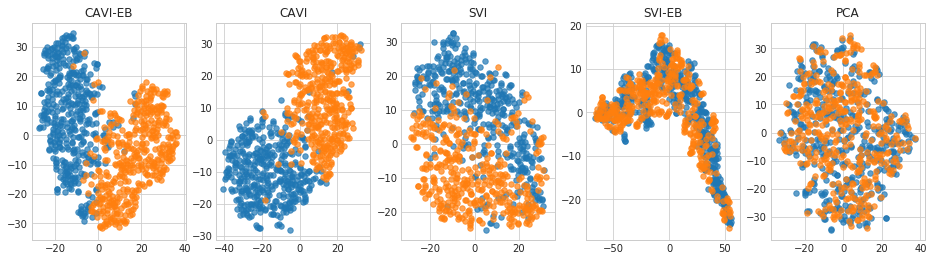

In [14]:
# Plot in decreasing silhouette order
U_list = [pcmf_tsne, pcmfeb_tsne, pcmfsvi_tsne, pcmfsvieb_tsne, pca_tsne]
title_list = ['CAVI', 'CAVI-EB', 'SVI', 'SVI-EB', 'PCA']

assert len(U_list) == len(title_list)

n_results = len(U_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[title_list.index(sorted_scores[i][0])][c_train==c, 0], U_list[title_list.index(sorted_scores[i][0])][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(sorted_scores[i][0])
plt.show()